# Question 1 - 10

- [Q.1 チャネル入れ替え](#q1)
- [Q.2 グレイスケール](#q2)
- [Q.3 二値化](#q3)
- [Q.4 大津の二値化](#q4)
- [Q.5 HSV変化](#q5)
- [Q.6 減色処理](#q6)
- [Q.7 平均プーリング](#q7)
- [Q.8 最大プーリング](#q8)
- [Q.9 ガウシアンフィルタ](#q9)
- [Q.10 メディアンフィルタ](#q10)

In [3]:

from skimage import io
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_orig = io.imread("../dataset/images/imori_256x256.png")

In [4]:
# Define my function.
def show_image(*images, **kwargs_imshow):
    num_images = len(images)

    fig, ax = plt.subplots(1, num_images)

    if num_images == 1:
        ax.imshow(images[0], **kwargs_imshow)
        return ax

    for i, img in enumerate(images):
        ax[i].imshow(img, **kwargs_imshow)

    plt.tight_layout()
    return fig

# <a id="q1">Q.1 チャネル入れ替え</a>

画像を読み込み、RGBをBGRの順に入れ替えよ。

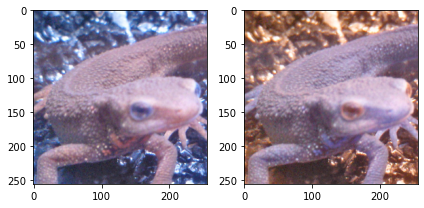

In [5]:
img_01 = img_orig.copy()

img_01 = img_01[:, :, ::-1]

show_image(img_orig, img_01)
plt.show()

# <a id="q2">Q.2 グレースケール Grayscale</a>

画像をグレースケールにせよ。 グレースケールとは、画像の輝度表現方法の一種であり下式で計算される。

$Grayscale = 0.2126 R + 0.7152 G + 0.0722 B$

それぞれの係数は人間の視覚の敏感さであり、Gに人間の最も強く反応し、Bにはあまり反応しないことを示す。

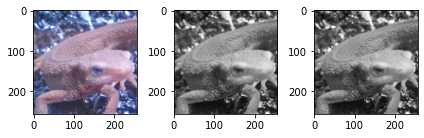

In [6]:
# oimg_02 = img_orig.copy()

img_02_cv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)

def rgb2gray(img):
    img = img.copy().astype(np.float32)
    rgb_weights = [0.2126, 0.7152, 0.0722]
    img_out = np.average(img, axis=2, weights=rgb_weights)
    img_out = np.clip(img_out, 0, 255).astype(np.uint8)
    return img_out
img_02_my = rgb2gray(img_orig)

show_image(img_orig, img_02_cv, img_02_my, cmap="gray")
plt.show()

# <a id="q3">Q.3 二値化, Binarization</a>

画像を二値化せよ。 二値化とは、画像を特定の値を閾値として黒と白の二値で表現する方法である。 ここでは、
1. グレースケール化
2. 閾値を128にして二値化する。

$
y = \begin{cases}
    0 & (if \, x < th) \\
    255  & (otherwise)
  \end{cases}
$

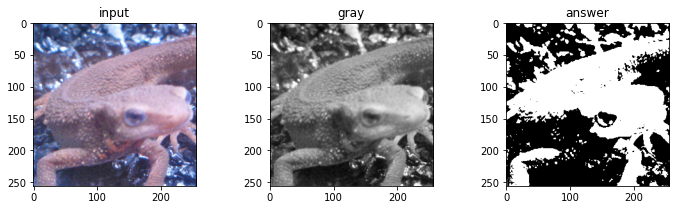

In [5]:
# opencv
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
th, img_bin = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 3, 2)
plt.title('gray')
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('answer')
plt.imshow(img_bin, cmap='gray')
plt.show()

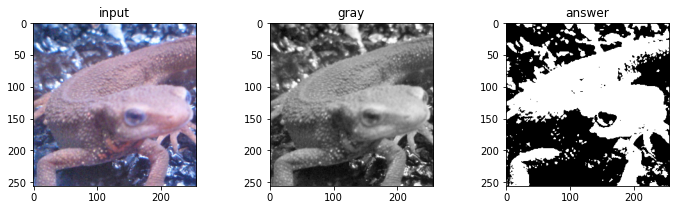

In [6]:
# answer
def binary(img, th):
    _img = img.copy()
    _img = np.minimum(_img // th, 1) * 255
    return _img.astype(np.uint8)

img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_bin = binary(img_gray, 127)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 3, 2)
plt.title('gray')
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('answer')
plt.imshow(img_bin, cmap='gray')
plt.show()

# <a id="q4">Q.4 大津の二値化, Otsu's binarization</a>

大津の二値化を実装せよ。 ここでは、
1. グレースケール化
2. 大津の二値化

大津の二値化とは判別分析法と呼ばれ、二値化における分離の閾値を自動決定する教師なし手法である。 これはクラス内分散とクラス間分散の比から計算される。

以下原理の説明。

まず、グレースケールの輝度値（ピクセルの値）のヒストグラムはこうなる。ここで赤線を閾値として、左側をクラス0、右側をクラス1として、この二つのクラスがバランスよく分離できれば良い二値化といえる。よって、クラス0と1の**分離度**を定義する。

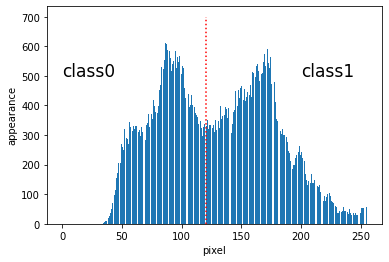

In [7]:
plt.hist(img_gray.ravel(), bins=255, rwidth=0.8, range=(0, 255))
plt.text(0, 500, 'class0', fontsize=17)
plt.text(200, 500, 'class1', fontsize=17)
plt.vlines(120, 0, 700, color='red', linestyles='dotted')
plt.xlabel('pixel')
plt.ylabel('appearance')
plt.show()

閾値tによってクラスタは次式で決定する。

$
cluster(y) = \begin{cases}
    0 & (if \, x <= th) \\
     1  & (otherwise)
  \end{cases}
$

**クラス内分散**は、次式のクラス0, 1の分散の重み付き和で定義される。

$\sigma_w^2 = w_0 \sigma_0^2 + w_1 \sigma_1^2$

ここで $w_x$は書くクラスに属するピクセル数、$\sigma_x^2$はクラスのピクセル数の分散。

**クラス間分散**は、各クラスの平均値が全体平均からどれだけ離れているかを表し、次式で定義される。

$
\sigma_b^2 = \frac{\omega_0}{\omega_0 + \omega_1} (M_0-M_t)^2 + \frac{\omega_1}{\omega_0 + \omega_1} (M_1-M_t)^2
$

$
\Biggl(
= \frac{\omega_0}{\omega_0 + \omega_1} (
\frac{p_0}{\omega_0} - \frac{p_0 + p_1}{\omega_0 + \omega_1})^2 + \frac{\omega_1}{\omega_0 + \omega_1} (
\frac{p_0}{\omega_1} - \frac{p_0 + p_1}{\omega_0 + \omega_1})^2
= \frac{\omega_0}{\omega_0 + \omega_1} (
\frac{p_0}{\omega_0} - \frac{p_0 + p_1}{\omega_0 + \omega_1})^2 + \frac{\omega_1}{\omega_0 + \omega_1} (
\frac{p_0}{\omega_1} - \frac{p_0 + p_1}{\omega_0 + \omega_1})^2
= \frac{\omega_0}{\omega_0 + \omega_1}
 (\frac{p_0 \omega_1 - p_1 \omega_0}{\omega_0 (\omega_0 + \omega_1) })^2
+ \frac{\omega_1}{\omega_0 + \omega_1} 
 (\frac{p_0 \omega_1 - p_1 \omega_0}{\omega_1 (\omega_0 + \omega_1) })^2
 = \frac{(p_0 \omega_1 - p_1 \omega_0)^2}{ (\omega_0 + \omega_1) ^ 3}
(\frac{1}{\omega_0} + \frac{1}{\omega_1})
= \frac{(p_0 \omega_1 - p_1 \omega_0)^2}{ (\omega_0 + \omega_1) ^ 2 \omega_0 \omega_1}
= \frac{\omega_0 \omega_1}{ (\omega_0 + \omega_1) ^ 2} 
(\frac{p_0}{\omega_0} - \frac{p_1}{\omega_1})^2\Biggl)
$

$= \frac{\omega_0 \omega_1}{ (\omega_0 + \omega_1) ^ 2} (M_0 - M_1)^2$

ここで、$M_t$は画像全体の平均値、$M_x$は各クラスの平均値を表す。

分離の度合いは一般的なクラス分類と同じ様に考え、クラス内分散が小さく、かつクラス間分散が大きくなるように定義される。
よって、次式で定義される分離度が最大になれば良い。

$X = \frac{\sigma_b^2}{\sigma_w^2}$

ここで、画像全体の分散はクラス間分散と、クラス内分散の和で定義される( $\sigma_t^2 = \sigma_w^2 + \sigma_b^2$ )ことを利用して、

$X = \frac{\sigma_b^2}{\sigma_w^2} = \frac{\sigma_b^2}{\sigma_t^2-\sigma_b^2}$

この分離度が最大となれば良くて、つまりクラス間分散が最大になれば良い。

${\rm argmax}_{t} \, X = {\rm argmax}_{t} \, \sigma_b^2$

以上のことから、閾値を[0, 255]の各値でクラス間分散を計算し、最大になる閾値が最適な閾値である。

threshold >> 129.0


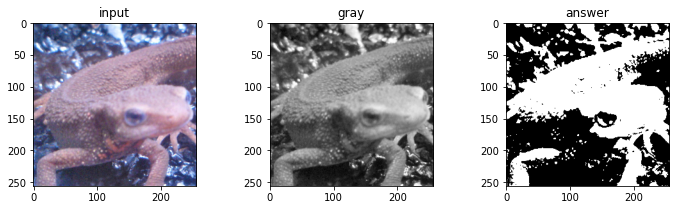

In [8]:
# opencv
th, img_bin = cv2.threshold(img_gray, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print('threshold >>', th)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 3, 2)
plt.title('gray')
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('answer')
plt.imshow(img_bin, cmap='gray')
plt.show()

<ipython-input-9-97cb582c44d7>:5: RuntimeWarning: Mean of empty slice.
  m0 = img[img <= th].mean() # mean class 0
/Users/yoshitonagaoka/dev/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


threshold >> 129


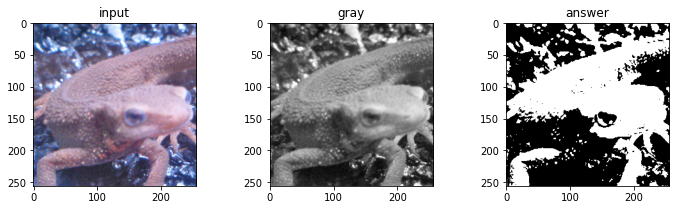

In [9]:
def otsu_thresh(img):
    max_vari = -1
    max_th = 0
    for th in range(1, 254):
        m0 = img[img <= th].mean() # mean class 0
        m1 = img[img > th].mean() # mean class 1
        w0 = img[img <= th].size # pixel num class 0
        w1 = img[img > th].size # pixel num class 1
        vari = w0 * w1 / ((w0 + w1) ** 2) * ((m0 - m1) ** 2) # inter class variance
        if vari > max_vari:
            max_th = th
            max_vari = vari
            
    img = binary(img, max_th)
            
    return max_th, img

th, img_bin = otsu_thresh(img_gray)
print('threshold >>', th)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 3, 2)
plt.title('gray')
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('answer')
plt.imshow(img_bin, cmap='gray')
plt.show()

# <a id="q5">Q.5 HSV変換, HSV transformation</a>

HSV変換を実装して、色相Hを反転（Hを180度反転）せよ。

HSV変換とは、**Hue(色相)、Saturation(彩度)、Value(明度)** で色を表現する手法である。

- Saturation ... 色の鮮やかさ。Saturationが低いと灰色さが顕著になり、くすんだ色となる。 ( $0 \leq S < 1$)
- Value ... 色の明るさ。Valueが高いほど白に近く、Valueが低いほど黒に近くなる。 ( $0 \leq V < 1$)
- Hue ... 色合いを0~360度で表現し、赤や青など色の種類を示す。 ( $0 \leq H < 1$) 色相は次の色に対応する。

ここでHueをとるのとRGBをとるのは何が違うかというと、色成分をとる時に違う、RGBでは $1678万 = 256^3$次元をとるため、緑を取りたいと思っても、範囲指定が複雑になる（G > 200 としてもRやBが200以上なら見た目が緑とは限らないから）。　逆にHueでは360次元で値をとるため、緑の指定が簡単になる。これを上手く活用できれば色成分の抽出が簡単に行えることもある。

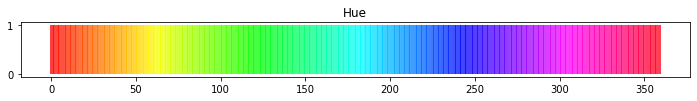

In [10]:
from matplotlib import cm
plt.figure(figsize=(12, 1))
plt.title('Hue')
for i in range(360):
    plt.vlines(i, 0, 1, color=cm.hsv(i / 360))
plt.show()

## RGB -> HSV　の変換

$v_{max} = max(R, G, B), \,\, v_{min} = min(R, G, B)$として、

$
H = \begin{cases}
    0 & ({\rm if} \, v_{min} = v_{max}) \\
    60 \frac{G - R}{v_{max} - v_{min}} + 60  & ({\rm if} \, B = v_{min}) \\
    60 \frac{B - G}{v_{max} - v_{min}} + 180  & ({\rm if} \, R = v_{min}) \\
    60 \frac{R - B}{v_{max} - v_{min}} + 300  & ({\rm if} \, G = v_{min}) \\
  \end{cases}
$

$S = v_{max} - v_{min}$

$V = v_{max}$

## HSV -> RGB の変換

$H' = \frac{H}{60}$

$X = S \, (1 - |H' {\rm mod}\, 2 - 1|)$

として、


$
(R, G, B) = (V - S) + \begin{cases}
    (S, X, 0) & ({\rm if} \, 0 \leq H' < 1) \\
    (X, C, 0) & ({\rm if} \, 1 \leq H' < 2) \\
    (0, C, X) & ({\rm if} \, 2 \leq H' < 3) \\
    (0, X, C) & ({\rm if} \, 3 \leq H' < 4) \\
    (X, 0, C) & ({\rm if} \, 4 \leq H' < 5) \\
    (C, 0, X) & ({\rm if} \, 5 \leq H' < 6) \\
  \end{cases}
$


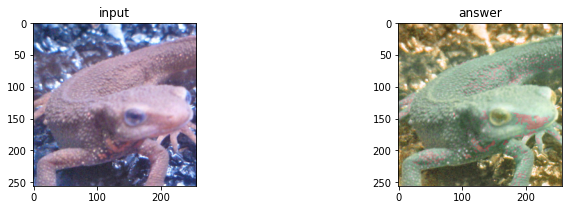

In [11]:
# opencv
hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV) # RGB -> HSV
hsv[..., 0] = (hsv[..., 0] + 90) % 180 # Hue of opencv is defined [0, 180]
img_hsv = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB) # HSV -> RGB
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_hsv)
plt.show()

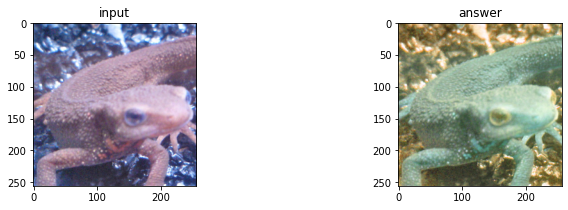

In [12]:
# answer
def rgb2hsv(img):
    _img = img.copy().astype(np.float32)# / 255
    v_max = _img.max(axis=2)
    v_min = _img.min(axis=2)
    v_argmin = _img.argmin(axis=2)
    hsv = np.zeros_like(_img, dtype=np.float32)
    r, g, b = np.split(_img, 3, axis=2)
    r, g, b = r[..., 0], g[..., 0], b[..., 0]

    diff = np.maximum(v_max - v_min, 1e-10)
    
    # Hue
    ind = v_argmin == 2
    hsv[..., 0][ind] = 60 * (g - r)[ind] / diff[ind] + 60
    ind = v_argmin == 0
    hsv[..., 0][ind] = 60 * (b - g)[ind] / diff[ind] + 180
    ind = v_argmin == 1
    hsv[..., 0][ind] = 60 * (r - b)[ind] / diff[ind] + 300
    ind = v_max == v_min
    hsv[..., 0][ind] = 0
    # Saturation
    hsv[..., 1] = v_max - v_min
    # Value
    hsv[..., 2] = v_max
    return hsv

def hsv2rgb(hsv):
    h, s, v = np.split(hsv, 3, axis=2)
    h, s, v = h[..., 0], s[..., 0], v[..., 0]
    _h = h / 60
    x = s * (1 - np.abs(_h % 2 - 1))
    z = np.zeros_like(x)
    vals = np.array([[s, x, z], [x, s, z], [z, s, x], [z, x, s], [x, z, s], [s, z, x]])
    
    img = np.zeros_like(hsv)
    
    for i in range(6):
        ind = _h.astype(int) == i
        for j in range(3):
            img[..., j][ind] = (v - s)[ind] + vals[i, j][ind]
            
    return np.clip(img, 0, 255).astype(np.uint8)
   
hsv = rgb2hsv(img_orig) # RGB -> HSV
hsv[..., 0] = (hsv[..., 0] + 180) % 360 # Hue of opencv is defined [0, 180]
img_hsv = hsv2rgb(hsv) # HSV -> RGB
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_hsv)
plt.show()

## H, S, Vをそれぞれ見てみる

- S：イモリ自体の色が茶色だから値が低くなっている
- V：同じイモリの色でも光が当たっている部分は値が大きくなっている。逆に影は値が小さい。これなら光の当たり具合などが取れそうだ

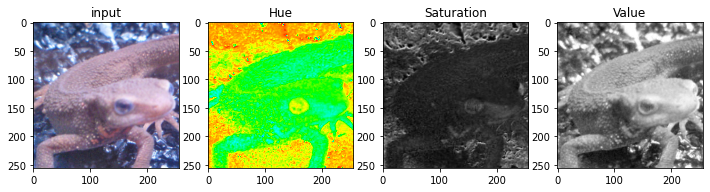

In [13]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(img_orig)

plt.subplot(1, 4, 2)
plt.title('Hue')
plt.imshow(hsv[..., 0] / 360, cmap='hsv')

plt.subplot(1, 4, 3)
plt.title('Saturation')
plt.imshow(hsv[..., 1], cmap='gray')

plt.subplot(1, 4, 4)
plt.title('Value')
plt.imshow(hsv[..., 2], cmap='gray')

plt.show()

## 他の画像でも見てみる

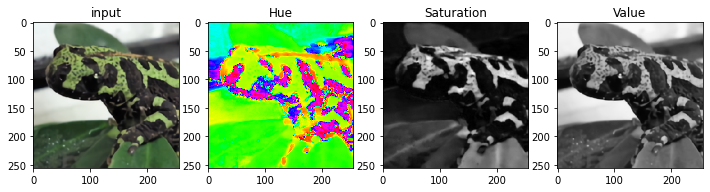

In [14]:
img_madara_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/madara_256x256.png')

hsv = rgb2hsv(img_madara_orig)
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(img_madara_orig)

plt.subplot(1, 4, 2)
plt.title('Hue')
plt.imshow(hsv[..., 0] / 360, cmap='hsv')

plt.subplot(1, 4, 3)
plt.title('Saturation')
plt.imshow(hsv[..., 1], cmap='gray')

plt.subplot(1, 4, 4)
plt.title('Value')
plt.imshow(hsv[..., 2], cmap='gray')

plt.show()

## Hueを見てみる

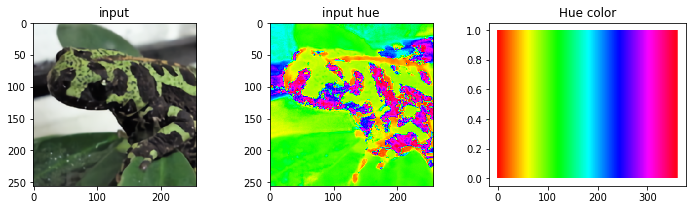

In [15]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.title('input')
plt.imshow(img_madara_orig)

plt.subplot(1, 3, 2)
plt.title('input hue')
plt.imshow(hsv[..., 0] / 360, cmap='hsv')

plt.subplot(1, 3, 3)
plt.title('Hue color')
for i in range(360):
    plt.vlines(i, 0, 1, color=cm.hsv(i / 360))
plt.show()

# <a id="q6">Q.6 減色, color subtraction</a>

ここでは画像の値を256^3から4^3、すなわちR,G,B を次式にしたがって{32, 96, 160, 224}の4値に減色せよ。 これは量子化操作である。 

$
y = \begin{cases}
   32 & ({\rm if} \, 0 \leq x < 64) \\
   96& ({\rm else if} \, 64 \leq x < 128) \\
   160 & ({\rm else if} \, 128 \leq x < 192) \\
   224 & ({\rm else if} \, 192 \leq x < 256) \\
  \end{cases}
$

これで色の複雑さをある程度抑えることができる。味のある画像にもなる。

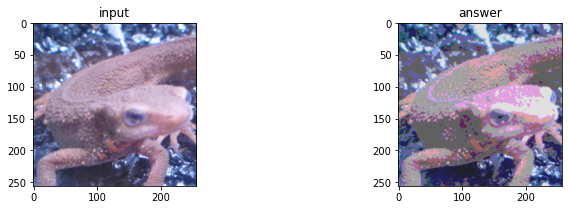

In [16]:
def color_subtraction(img, div=4):
    th = 256 // div
    return np.clip(img // th * th + th // 2, 0, 255)

img_sub = color_subtraction(img_orig) # color subtract

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_sub)
plt.show()

## 減色を8値にしてみる

8値でも元の画像に相当近い見た目を保持できている。この時のRGBは $512 = 8 ^ 3$なので、元の$1678万 = 256 ^ 3$に比べると色空間はかなり削減できてる。

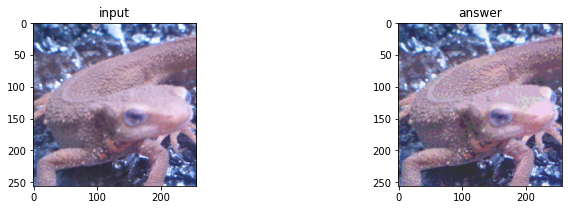

In [17]:
img_sub = color_subtraction(img_orig, div=8) # color subtract

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_sub)
plt.show()

# ここからフィルタリング地獄が始まる

# <a id="q7">Q.7 平均プーリング, average pooling</a>

ここでは画像をグリッド分割(ある固定長の領域に分ける)し、かく領域内(セル)の平均値でその領域内の値を埋める。 このようにグリッド分割し、その領域内の代表値を求める操作はPooling(プーリング) と呼ばれる。 これらプーリング操作はCNN(Convolutional Neural Network) において重要な役割を持つ。

平均プーリングは次式で定義される。ここでいうRはプーリングを行う領域である。つまり、3x3の領域でプーリングを行う。|R|=3x3=9となる。

$y = \frac{1}{|R|}\sum_{i\in R}x_i$

<img src="assets/mean_pooling_result.png" width=300>

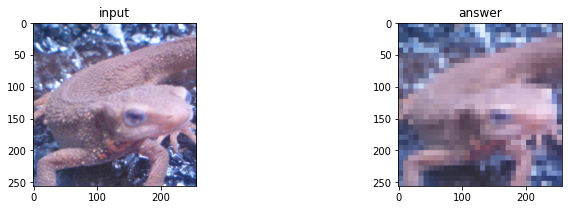

In [18]:
def pool_average(img, ksize_h=8, ksize_w=8):
    _img = img.copy().astype(np.float32)
    
    # padding
    h, w = img.shape[:2]
    outer_h = h % ksize_h
    pad_top = outer_h // 2
    pad_bottom = outer_h - pad_top
    outer_w = w % ksize_w
    pad_left = outer_w // 2
    pad_right = outer_w - pad_left
    
    _img = np.pad(_img, [(pad_top, pad_bottom), (pad_left, pad_right), (0, 0)], 'edge')
    out = np.zeros_like(_img)
    
    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
    
    # filtering
    for iy in range(0, new_h, ksize_h):
        for ix in range(0, new_w, ksize_w):
            for ic in range(c):
                out[iy : iy + ksize_h, ix : ix + ksize_w, ic] = _img[iy : iy + ksize_h, ix : ix + ksize_w, ic].mean()
            
    out = out[pad_top : pad_top + h, pad_left : pad_left + w]
    return np.clip(out, 0, 255).astype(np.uint8)

img_pool = pool_average(img_orig) # pooling

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_pool)
plt.show()

## フィルタサイズを大きくすると

フィルタサイズが大きくなると、ピンボケのような画像になる。

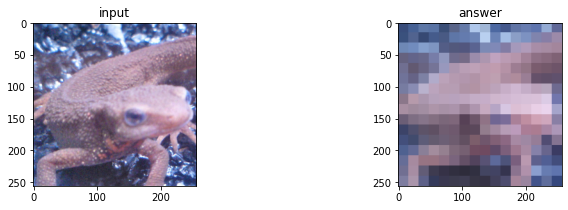

In [19]:
img_pool = pool_average(img_orig, ksize_h=16, ksize_w=16) # pooling

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_pool)
plt.show()

# <a id="q8">Q.8 最大プーリング, max pooling</a>

平均値でなく、最大値を出力せよ。

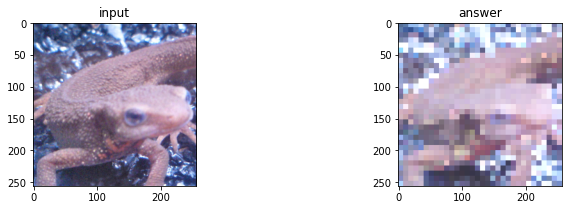

In [20]:
def pool_max(img, ksize_h=8, ksize_w=8):
    _img = img.copy().astype(np.float32)
    
    # padding
    h, w = img.shape[:2]
    outer_h = h % ksize_h
    pad_top = outer_h // 2
    pad_bottom = outer_h - pad_top
    outer_w = w % ksize_w
    pad_left = outer_w // 2
    pad_right = outer_w - pad_left
    
    _img = np.pad(_img, [(pad_top, pad_bottom), (pad_left, pad_right), (0, 0)], 'edge')
    out = np.zeros_like(_img)
    
    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
    
    # filtering
    for iy in range(0, new_h, ksize_h):
        for ix in range(0, new_w, ksize_w):
            for ic in range(c):
                out[iy : iy + ksize_h, ix : ix + ksize_w, ic] = _img[iy : iy + ksize_h, ix : ix + ksize_w, ic].max()
            
    out = out[pad_top : pad_top + h, pad_left : pad_left + w]
    return np.clip(out, 0, 255).astype(np.uint8)

img_pool = pool_max(img_orig) # pooling

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_pool)
plt.show()

# <a id="q9">Q.9 ガウシアンフィルタ, gaussian filter</a>

イモリの画像がノイズだらけになってしまった！　これをどうにかしたいので、ガウシアンフィルタ(3x3、標準偏差1.3)を実装し、imori_256x256_noise.pngのノイズを除去せよ。

ガウシアンフィルタとは画像の平滑化（滑らかにする）を行うフィルタの一種であり、ノイズ除去にも使われる。

ノイズ除去には他にも、メディアンフィルタ(Q.10)、平滑化フィルタ(Q.11)、LoGフィルタ(Q.19)などがある。

ガウシアンフィルタは注目画素の周辺画素を、ガウス分布による重み付けで平滑化し、次式で定義される。 このような重みはカーネルやフィルタと呼ばれる。

ただし、画像の端はこのままではフィルタリングできないため、画素が足りない部分は0で埋める。これを0パディングと呼ぶ。 かつ、重みは正規化する。(sum g = 1)

重みはガウス分布から次式になる。

$k(x, y) = \frac{1}{2 \pi \sigma^2} e^{- \frac{x^2 + y^2}{2 \sigma ^ 2}}$

例えば$\sigma = 1.3$、カーネルサイズ3の場合は、次式となる。

$
k = \frac{1}{16}
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$

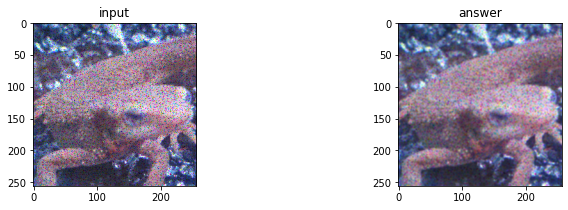

In [21]:
img_noise_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_noise.png')

img_gau = cv2.GaussianBlur(img_noise_orig, (3,3), 1.3)
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_noise_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_gau)
plt.show()

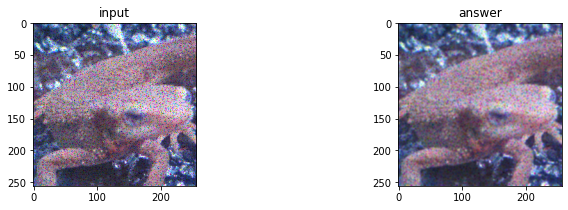

In [22]:
def filter_gaussian(img, ksize=(3, 3), sigma=1.3):
    _img = img.copy().astype(np.float32)
    ksize_h, ksize_w = ksize
    
    # padding
    h, w = img.shape[:2]
    pad_top, pad_bottom = ksize_h, ksize_h
    pad_left, pad_right = ksize_w, ksize_w
    
    _img = np.pad(_img, [(pad_top, pad_bottom), (pad_left, pad_right), (0, 0)], 'edge')
    out = np.zeros_like(_img)
    
    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
    
    # prepare kernel
    k = np.zeros([ksize_h, ksize_w])
    for iy in range(ksize_h):
        for ix in range(ksize_w):
            k[iy, ix] = 1 / (2 * np.pi * (sigma ** 2)) * np.exp(- ((ix - ksize_w // 2) ** 2 + (iy - ksize_h // 2) ** 2) / (2 * sigma ** 2))
 
    k /= k.sum()

    # filtering
    for iy in range(new_h - ksize_h):
        for ix in range(new_w - ksize_w):
            for ic in range(c):
                out[iy, ix, ic] = np.sum(_img[iy : iy + ksize_h, ix : ix + ksize_w, ic] * k)
            
    out = out[pad_top : pad_top + h, pad_left : pad_left + w]
    return np.clip(out, 0, 255).astype(np.uint8)

img_gau = filter_gaussian(img_noise_orig, (3, 3), 1.3)
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_noise_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_gau)
plt.show()

## カーネルサイズや$\sigma$を変えてみる

- カーネルサイズを大きくすると、画像がぼやける。逆にぼやけたことでノイズが分かりにくくなったと言える。
- $\sigma$を大きくすると、ノイズがかなり消えた。Gaussianの$\sigma$は周辺との重みバランスが均衡化されるので、ノイズが消えやすくなった

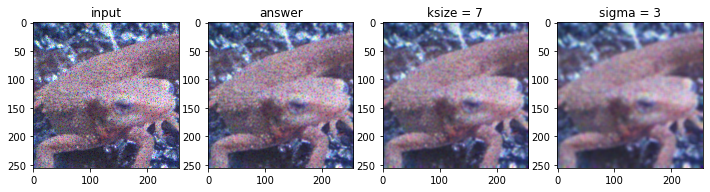

In [23]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(img_noise_orig)

plt.subplot(1, 4, 2)
plt.title('answer')
img_gau = filter_gaussian(img_noise_orig, (3, 3), 1.3)
plt.imshow(img_gau)

plt.subplot(1, 4, 3)
plt.title('ksize = 7')
img_gau = filter_gaussian(img_noise_orig, (7, 7), 1.3)
plt.imshow(img_gau)

plt.subplot(1, 4, 4)
plt.title('sigma = 3')
img_gau = filter_gaussian(img_noise_orig, (7, 7), 3)
plt.imshow(img_gau)
plt.show()

## Gaussianについて

$sigma$が広がると、グラフが横広がりになる。つまり、 GaussianFilterでは重みが均一化されるので、Meanフィルタに近付く。

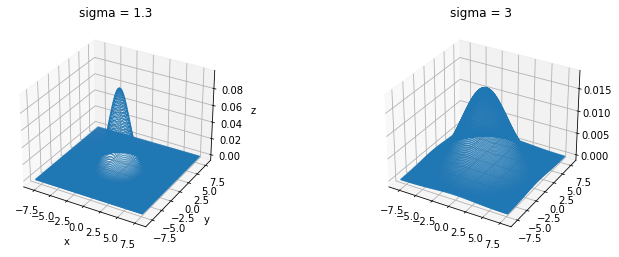

In [24]:
from mpl_toolkits.mplot3d import Axes3D

def gaussian(sigma):
    x = np.arange(-8, 8, 0.1) 
    y = np.arange(-8, 8, 0.1)
    x, y = np.meshgrid(x, y)
    z = 1 / (2 * np.pi * (sigma ** 2)) * np.exp(- (x ** 2 + y ** 2) / (2 * sigma ** 2))
    return x, y, z

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
x, y, z = gaussian(1.3)
ax.scatter3D(x, y, z, s=1, marker='.')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_title('sigma = 1.3')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
x, y, z = gaussian(3)
ax2.scatter3D(x, y, z, s=1, marker='.')
ax2.set_title('sigma = 3')

plt.show()

# <a id="q10">Q.10 メディアンフィルタ, median filter</a>

次にメディアンフィルタ(3x3)を実装し、imori_256x256_noise.jpgのノイズを除去せよ。

メディアンフィルタとは画像の平滑化を行うフィルタの一種である。

これは注目画素の3x3の領域内の、メディアン値(中央値)を出力するフィルタである。

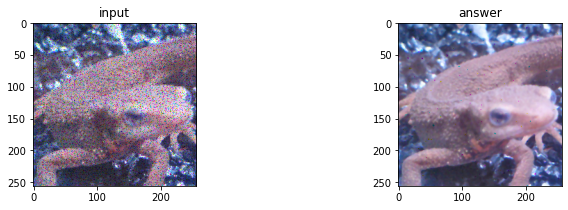

In [25]:
img_med = cv2.medianBlur(img_noise_orig, 3) # median filtering

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_noise_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_med)
plt.show()

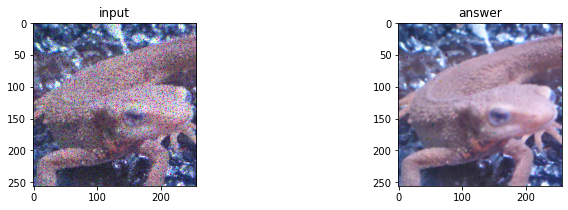

In [26]:
def filter_median(img, ksize=(3, 3)):
    _img = img.copy().astype(np.float32)
    ksize_h, ksize_w = ksize
    
    # padding
    h, w = img.shape[:2]
    pad_top, pad_bottom = ksize_h, ksize_h
    pad_left, pad_right = ksize_w, ksize_w
    
    _img = np.pad(_img, [(pad_top, pad_bottom), (pad_left, pad_right), (0, 0)], 'edge')
    out = np.zeros_like(_img)
    
    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]

    # filtering
    for iy in range(new_h - ksize_h):
        for ix in range(new_w - ksize_w):
            for ic in range(c):
                out[iy, ix, ic] = np.median(_img[iy : iy + ksize_h, ix : ix + ksize_w, ic])
            
    out = out[pad_top : pad_top + h, pad_left : pad_left + w]
    return np.clip(out, 0, 255).astype(np.uint8)

img_med = filter_median(img_noise_orig, (3, 3))
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_noise_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_med)
plt.show()

## カーネルサイズを大きくすると

ksize=3でもかなりノイズが消えたが、カーネルサイズを大きくすると、画像がすこし角ついたようになる。
これはこれで味がある画像だ。

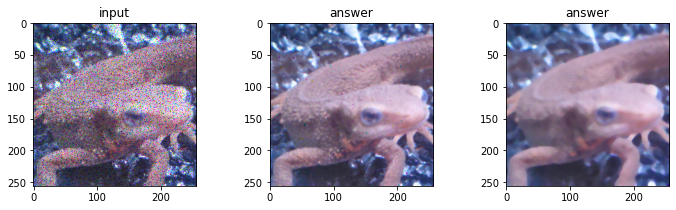

In [27]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.title('input')
plt.imshow(img_noise_orig)

plt.subplot(1, 3, 2)
plt.title('answer')
img_med = filter_median(img_noise_orig, (3, 3))
plt.imshow(img_med)

plt.subplot(1, 3, 3)
plt.title('answer')
img_med = filter_median(img_noise_orig, (7, 7))
plt.imshow(img_med)
plt.show()

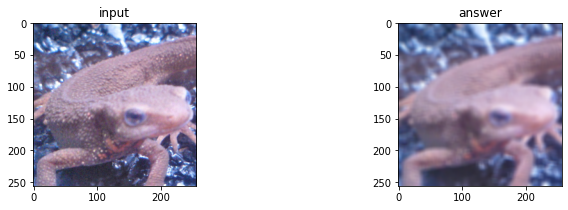

In [28]:
# opencv
kernel = np.ones((8, 8),np.float32) / 8 ** 2
img_pool = cv2.filter2D(img_orig, -1, kernel)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(img_pool, cmap='gray')
plt.show()